In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 9)

import warnings
warnings.filterwarnings('ignore')

In [2]:
%cd ~/PycharmProjects/pqr/

import pqr

/home/akbabkin/PycharmProjects/pqr


# Загрузка и предобработка данных

In [3]:
# загружаем цены
prices = pd.read_excel('~/notebooks/pqr/factors/monthlyprice.xlsx', index_col=0, parse_dates=True)
# загружаем данные по рыночной капитализации
mcap = pd.read_excel('~/notebooks/pqr/factors/mcap.xlsx', index_col=0, parse_dates=True)
# загружаем данные по среднему объему торгов за день
volume = pd.read_excel('~/notebooks/pqr/factors/betafilter.xlsx', index_col=0, parse_dates=True)
# загружаем бенчмарк
imoex = pd.read_excel('~/notebooks/pqr/factors/imoex.xlsx', index_col=0, parse_dates=True)

In [4]:
# приводим все таблицы к одинаковому формату
prices, mcap, volume = pqr.correct_matrices(prices, mcap, volume)

# убираем значения, обозначающие nan
prices, mcap, volume = pqr.replace_with_nan(prices, mcap, volume, to_replace=[0])

# Переходим к факторам

In [5]:
# основной фактор для отбора бумаг -- фактор размера, его пока не будем трогать
# фильтрующий фактор преобразуем сразу с looking_period=1 во избежание look-ahead bias
liquidity = pqr.factorize(
    factor=volume,
    is_dynamic=False,
    looking_period=1
)
liquidity_threshold = pqr.Thresholds(lower=10_000_000)

In [6]:
# у нас есть индекс-бенчмарк
benchmark = pqr.benchmark_from_index(imoex['IMOEX'])

# 1 способ использования: строим факторную модель

Данный способ хорошо подходит для первичного анализа фактора и научных исследований наличия факторов на том или ином рынке.

Сначала построим одну модель с параметрами 3-0-3

In [7]:
# вспоминаем, что работаем с фактором размера
size_303 = pqr.factorize(
    factor=mcap,
    is_dynamic=False,
    looking_period=3,
    lag_period=0,
    holding_period=3
)

# "обучаем" факторную модель
portfolios = pqr.fit_factor_model(
    stock_prices=prices,
    factor=size_303,
    filtering_factor=liquidity,
    filtering_thresholds=liquidity_threshold,
    add_wml=True, # добавим wml-портфель
    is_bigger_better=False,  # укажем, что чем выше размер, тем менее привлекательна компания (для wml)
    n_quantiles=3
)

,"q(0.00, 0.33)","q(0.33, 0.67)","q(0.67, 1.00)",wml_portfolio
"Alpha, %",-0.30,0.12,-0.06,-0.24
Beta,1.08,0.95,0.94,0.14
Sharpe Ratio,0.41,0.58,0.57,-0.04
"Mean Return, %",1.10,1.35,1.16,-0.06
"Mean Excessive Return, %",-0.21,0.04,-0.15,-1.37
"Volatility, %",9.20,8.06,7.03,5.06
Benchmark Correlation,0.84,0.85,0.96,0.20
"Profitable Periods, %",55.12,58.05,60.00,46.83
"Maximum Drawdown, %",-145.64,-101.44,-103.51,-70.42


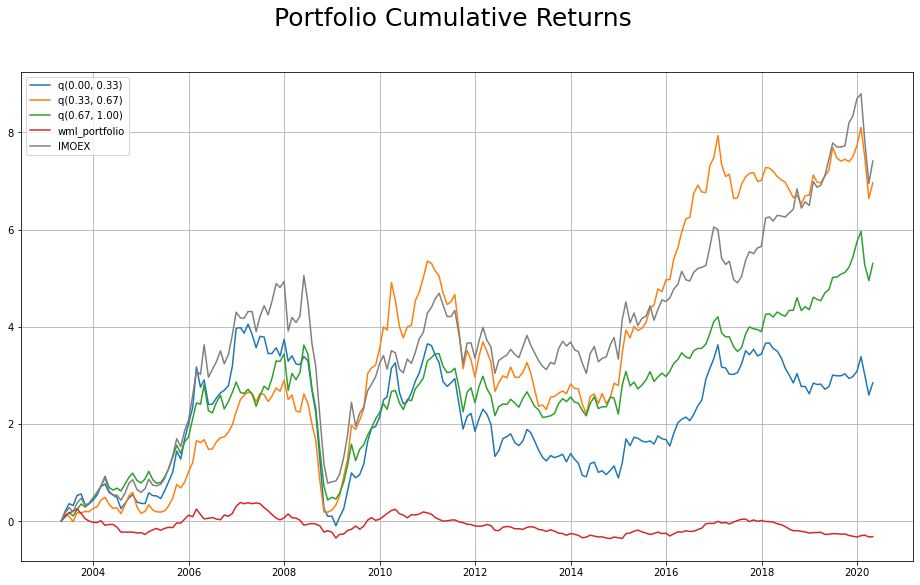

In [8]:
pqr.plot_cumulative_returns(*portfolios, benchmark=benchmark)
pqr.compare_portfolios(*portfolios, benchmark=benchmark)

## Поищем модель получше

Результаты получились не очень: ни один портфель не победил бенчмарк. Скорее всего, параметры подобраны неправильно, но вручную перебирать их может быть довольно-таки трудозатратно. К тому же, есть риск пропустить хорошую модель.

Поэтому воспользуемся перебором параметров.

In [9]:
%%time
%%capture

results = pqr.grid_search(
    stock_prices=prices,
    factor=mcap, # здесь передаем сырые данные, которые впоследствии будут факторизованы по-разному
    is_dynamic=False,
    looking_periods=[1, 3, 6, 9, 12],
    lag_periods=[0, 1],
    holding_periods=[1, 3, 6, 9, 12],
    filtering_factor=liquidity,
    filtering_thresholds=liquidity_threshold,
    benchmark=benchmark
)

CPU times: user 5 s, sys: 8.26 ms, total: 5.01 s
Wall time: 5.01 s


Теперь у нас есть словарь со статистикой для каждой модели. Посмотрим, что для нашей изначальной модели статистика все та же (с тем лишь исключением, что перебирали мы без WML-портфелей).

In [10]:
results[(3, 0, 3)]

,"q(0.00, 0.33)","q(0.33, 0.67)","q(0.67, 1.00)"
"Alpha, %",-0.30,0.12,-0.06
Beta,1.08,0.95,0.94
Sharpe Ratio,0.41,0.58,0.57
"Mean Return, %",1.10,1.35,1.16
"Mean Excessive Return, %",-0.21,0.04,-0.15
"Volatility, %",9.20,8.06,7.03
Benchmark Correlation,0.84,0.85,0.96
"Profitable Periods, %",55.12,58.05,60.00
"Maximum Drawdown, %",-145.64,-101.44,-103.51


На данный момент не реализован поиск лучшего портфеля по таргету, но его можно сделать самостоятельно довольно простой функцией. Найдем портфель с наибольшим коэффициентом Шарпа.

In [11]:
def find_best_model(results, target='Alpha, %'):
    model_params = None
    max_target = -np.inf
    best_portfolio = None
    for params, stats in results.items():
        max_value = stats.loc[target].max()
        if max_value > max_target:
            model_params = params
            best_portfolio = stats.columns[stats.loc[target].argmax()]
            max_target = max_value
    return model_params, best_portfolio

In [12]:
find_best_model(results, target='Sharpe Ratio')

((1, 0, 1), 'q(0.33, 0.67)')

У нас получилось, что лучшая модель имеет параметры 1-0-1, а портфель состоит из квантилей от 1/3 до 2/3. Построим такую модель.

In [13]:
portfolios = pqr.fit_factor_model(
    stock_prices=prices,
    factor=pqr.factorize(mcap, looking_period=1, holding_period=1),
    filtering_factor=liquidity,
    filtering_thresholds=liquidity_threshold,
    add_wml=True,
    n_quantiles=3
)

,"q(0.00, 0.33)","q(0.33, 0.67)","q(0.67, 1.00)",wml_portfolio
"Alpha, %",-0.57,0.38,-0.07,0.50
Beta,1.11,0.93,0.95,-0.15
Sharpe Ratio,0.32,0.68,0.57,0.20
"Mean Return, %",0.88,1.60,1.17,0.30
"Mean Excessive Return, %",-0.43,0.30,-0.13,-1.01
"Volatility, %",9.41,8.21,7.13,5.30
Benchmark Correlation,0.84,0.81,0.96,-0.21
"Profitable Periods, %",54.59,60.39,59.42,54.11
"Maximum Drawdown, %",-161.96,-107.56,-107.28,-67.01


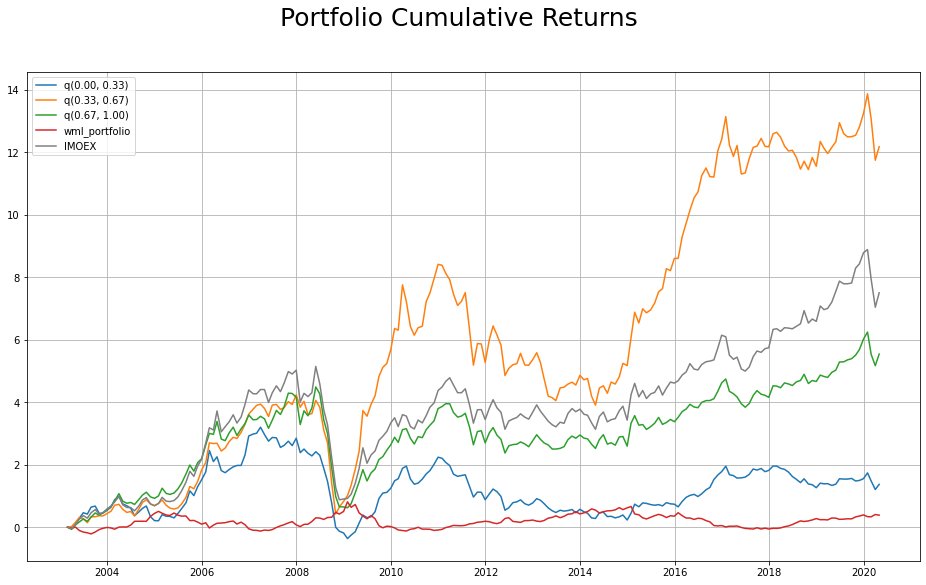

In [14]:
pqr.plot_cumulative_returns(*portfolios, benchmark=benchmark)
pqr.compare_portfolios(*portfolios, benchmark=benchmark)

### Лучший портфель поподробнее

Шарп получился меньше 1, не очень впечатляет, но посмотрим поподробнее на данный портфель. После обучения модели все портфели сохраняются в список, нас интересует 2 элемент.

In [15]:
best_portfolio = portfolios[1]

Посмотрим на изменение годовой беты портфеля: видно, что в основном бета колеблется около 1, но в последние годы снизилась почти на половину.

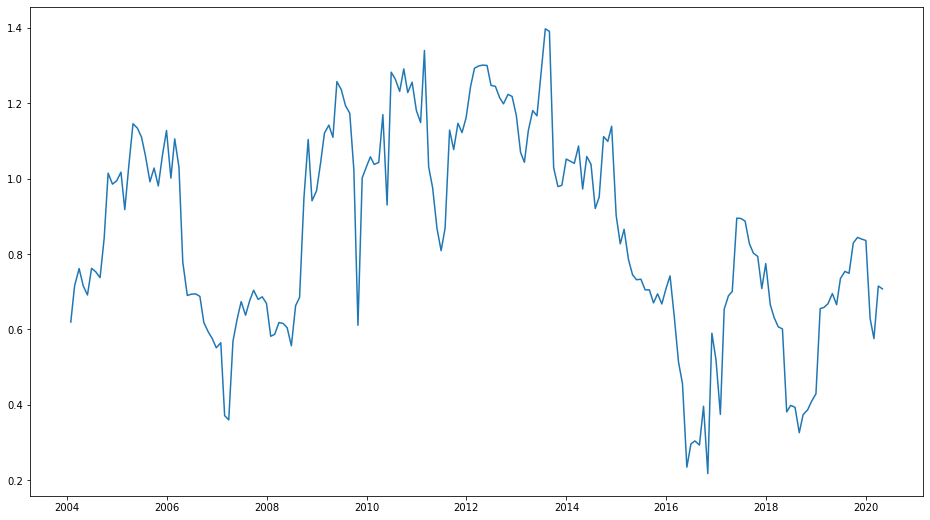

In [16]:
plt.plot(pqr.rolling_beta(best_portfolio, benchmark))

Годовой Шарп выглядит совсем непривлекательно - американские горки.

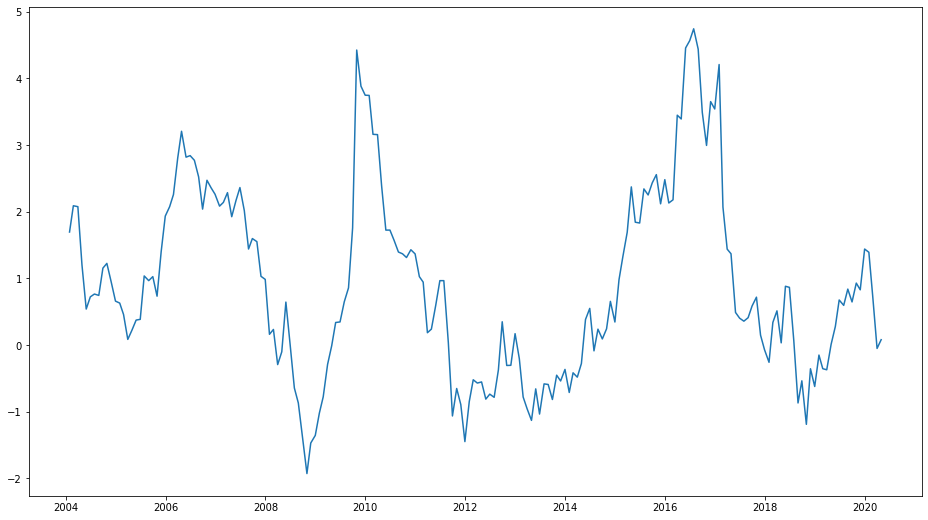

In [17]:
plt.plot(pqr.rolling_sharpe(best_portfolio))

Годовая просадка в целом не так ужасно выглядит, но в 2008 падение стоило бы всего портфеля, и даже чуть больше, поэтому окончательно отметаем данный портфель.

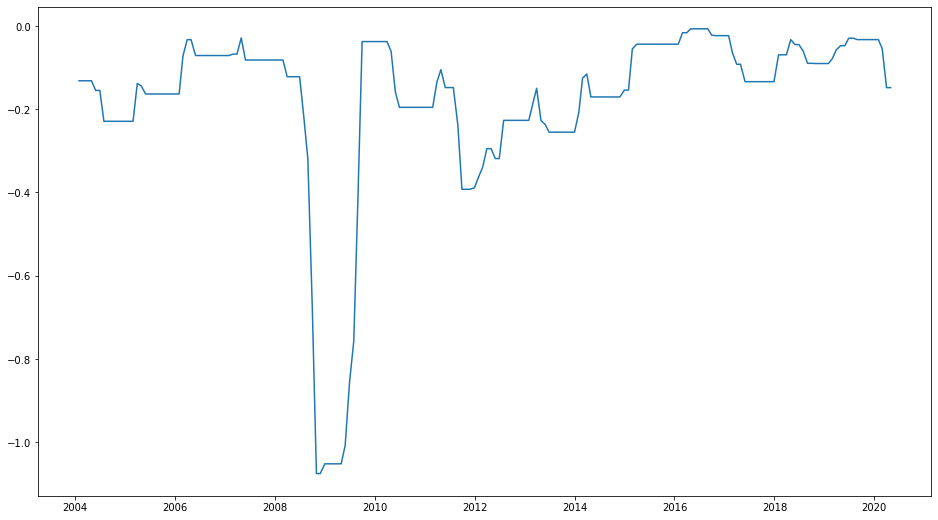

In [18]:
plt.plot(pqr.rolling_max_drawdown(best_portfolio))

# 2 способ использования: строим и настраиваем портфель

В примере выше мы хотели рассмотреть всего 1 портфель, для этого нам не было необходимости строить еще 2 дополнительных. Но данная глава нужна не только для того, чтобы облегчить расчеты, иногда нас может интересовать конкретный портфель, и мы хотим сконцентрироваться на его настройке. Ну или требуется более подробно изучить фактор.

Но для этого придется чуть больше погрузиться в библиотеку.

In [19]:
# создадим 2 портфеля

# портфель, включающий в себя топ-10 акций по значению фактора
# для фактора размера это в действительности топ-10 худших компаний, т.е. топ-10 с наиболее высокой капитализацией
top10 = pqr.Top(10, 1)

# портфель, включающий 10% бумаг с наименьшим значением фактора
q01 = pqr.Quantiles(0, 0.1)

In [20]:
# проинвестируем в оба в стратегию 3-0-3
top_portfolio = pqr.factor_portfolio(
    prices,
    size_303,
    top10,
    filtering_factor=liquidity,
    filtering_thresholds=liquidity_threshold,
    name='top 10 size 3-0-3'
)

q_portfolio = pqr.factor_portfolio(
    prices,
    size_303,
    q01,
    filtering_factor=liquidity,
    filtering_thresholds=liquidity_threshold,
    name='q(0, 0.1) size 3-0-3'
)

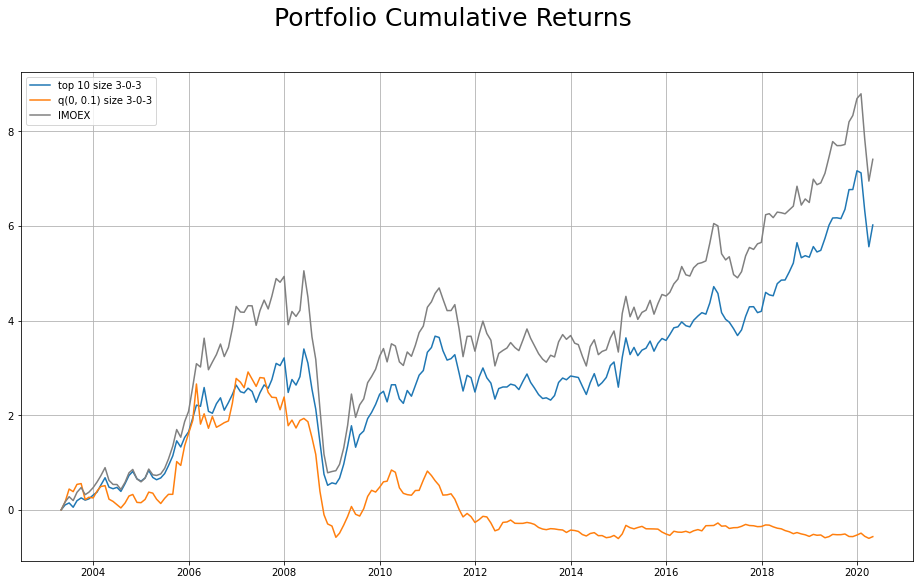

In [21]:
pqr.plot_cumulative_returns(top_portfolio, q_portfolio, benchmark=benchmark)

Получились интересные результаты: топ-10 компаний по капитализации почти полностью копируют индекс МосБиржи, но все-таки ему проигрывают. 10% компаний с наименьшей капитализацией неплохо смотрелись до 2008 года, и даже после него отскочили сильнее, чем индекс, но с 2012 они топчатся на месте.

Окей, возьмем в разработку портфель из топ-10 компаний по капитализации. Попробуем взвесить его по ней же, получится по сути своей смарт-бета портфель (за тем лишь исключением, что фактор размера мы используем в другую сторону:)).

In [22]:
size_w = pqr.factorize(
    factor=mcap,
    looking_period=1
)

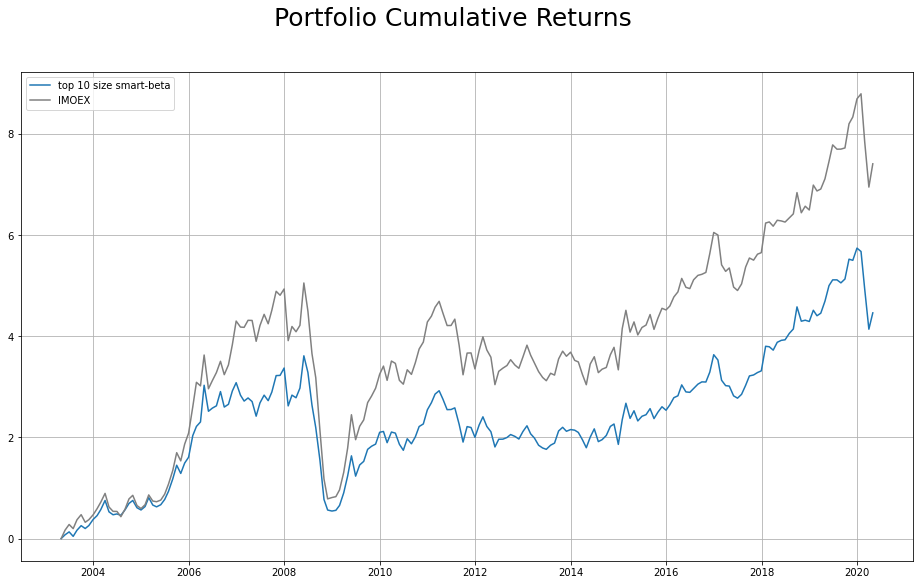

In [23]:
top_portfolio = pqr.factor_portfolio(
    prices,
    size_303,
    top10,
    filtering_factor=liquidity,
    filtering_thresholds=liquidity_threshold,
    weighting_factor=size_w,
    weighting_factor_is_bigger_better=True, # взвешивем прямолинейно
    name='top 10 size smart-beta'
)

pqr.plot_cumulative_returns(top_portfolio, benchmark=benchmark)

Как бы это не выглядело странным, но после перехода от равных весов к взвешиванию по капитализации, портфель довольно сильно отстал от бенчмарка. Попробуем, наоборот.

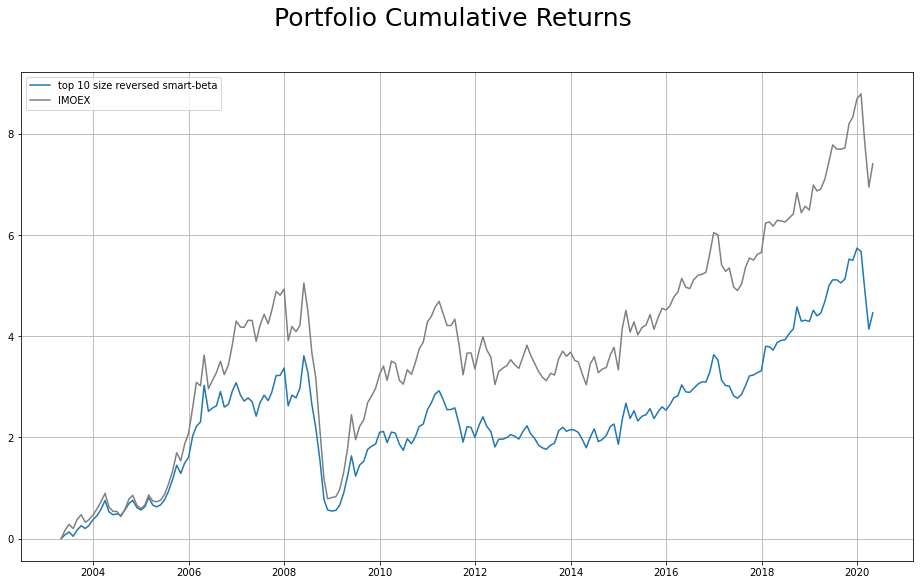

In [24]:
top_portfolio = pqr.factor_portfolio(
    prices,
    size_303,
    top10,
    filtering_factor=liquidity,
    filtering_thresholds=liquidity_threshold,
    weighting_factor=size_w,
    weighting_factor_is_bigger_better=True,
    name='top 10 size reversed smart-beta'
)

pqr.plot_cumulative_returns(top_portfolio, benchmark=benchmark)

Отставание от бенчмарка сократилось, но по-прежнему больше, чем при портфеле с равными весами. Обогнать бенчмарк на основе фактора размера на российском рынке не вышло, но это мы еще не пробовали другие параметры. Пока признаем поражение и посмотрим, что еще можно достать из портфеля.

## Немного аналитики по портфелю

Посмотрим, какие вообще компании в основном были в нашем портфеле. Абсолютными лидерами стали Сбербанк, Сургутнефтегаз, Норникель и Лукойл. Выглядит так, что они были в нашем портфеле вообще всегда.

<AxesSubplot:>

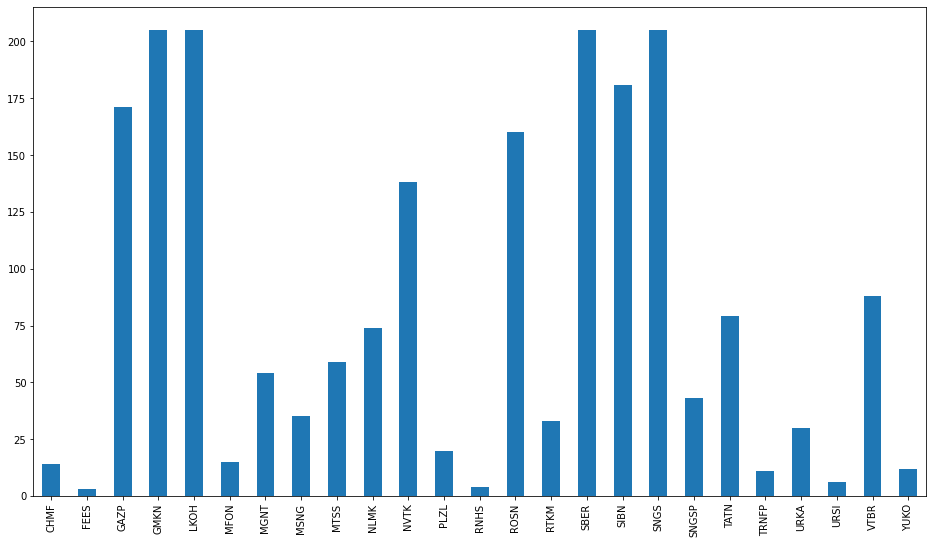

In [25]:
picks = top_portfolio.positions != 0
at_least_1_pick = (picks.sum() > 0)
picks[picks.columns[at_least_1_pick]].sum().plot.bar()

По графику прибыльных периодов видно, что вероятность прибыльного периода колеблется около 50%, но чаще все-таки выше.

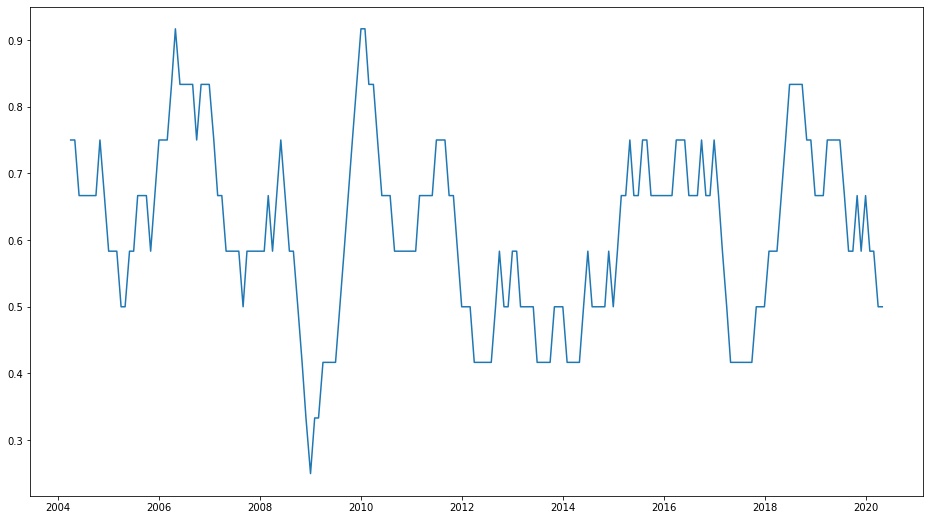

In [26]:
plt.plot(pqr.rolling_profitable_periods_share(top_portfolio))

Также видно, что действительно портфель не обгоняет бенчмарк почти никогда.

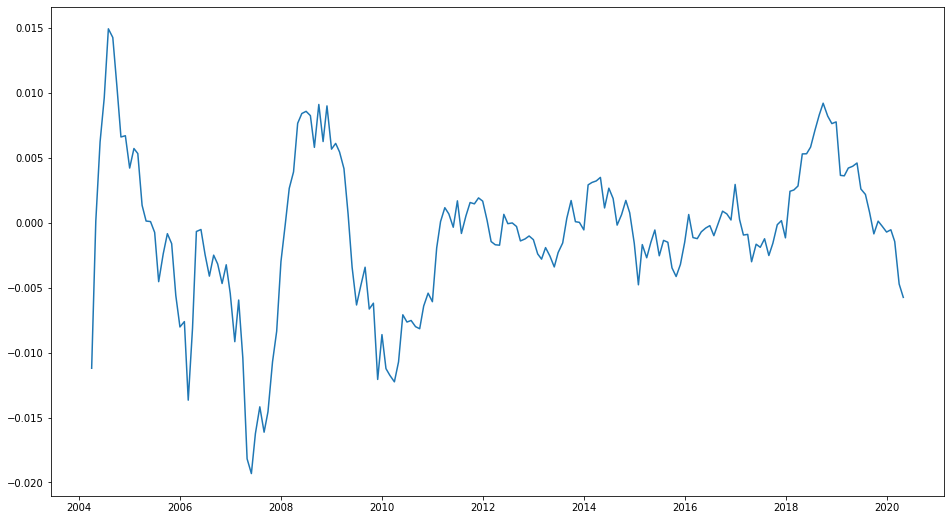

In [27]:
plt.plot(pqr.rolling_mean_excessive_return(top_portfolio, benchmark))

Посмотрим также на summary-статистики.

In [28]:
pqr.summary(top_portfolio, benchmark)

Alpha, %                    -0.14
Beta                         0.95
Sharpe Ratio                 0.53
Mean Return, %               1.09
Mean Excessive Return, %    -0.22
Volatility, %                7.12
Benchmark Correlation        0.96
Profitable Periods, %       60.98
Maximum Drawdown, %        -98.13
Name: top 10 size reversed smart-beta, dtype: float64

# Случайный тест

Суть теста заключается в том, что мы строим много (для примера 1000) случайных портфелей. Случайный портфели строятся так:
* сначала считаем, сколько акций мы купили в каждый период времени
* затем выбираем то же количество акций случайным образом для каждого периода
* повторяем это 1000 раз

Затем вспоминаем, что тестируем мы по таргету - метрике, которую мы хотим проанализировать для нашего портфеля. Считаем метрику у всех 1000 случайных портфелей, получилось распределение случайной величины - метрики. Берем несколько (для примера 5) квантилей этой случайной величины, и отбираем только те портфели, которые являются пограничными для каждого квантиля по этой метрике. На выходе получаем столбец из значений метрики-таргета и массив портфелей, соответствующих значениям. Можем отрисовать их кумулятивные доходности, например.

Есть одна проблема: таргет - это любая функция, которая на вход принимает портфель, и возвращает число. Благодаря этому вы можете написать свою метрику и запросто провести тест на ее основе. Однако минус данного подхода в том, что нельзя напрямую запихнуть метрики, для расчета которых необходим бенчмарк.

In [29]:
import functools as ft

# но в этом нам поможет встроенный в python модуль functools
# в нем есть функция partial, которая принимает на вход функцию и аргументы, которые необходимо зафиксировать
# зафиксируем бенчмарк для расчета альфы, и готово: теперь наша новая функция 
target_alpha = ft.partial(pqr.alpha, benchmark=benchmark)

In [30]:
%%time
%%capture

target_values, random_portfolios = pqr.random_test(
    prices, top_portfolio, target_alpha, n_quantiles=5,
    n=1000, 
    filtering_factor=liquidity,
    filtering_thresholds=liquidity_threshold,
)

CPU times: user 17.9 s, sys: 288 ms, total: 18.2 s
Wall time: 18.2 s


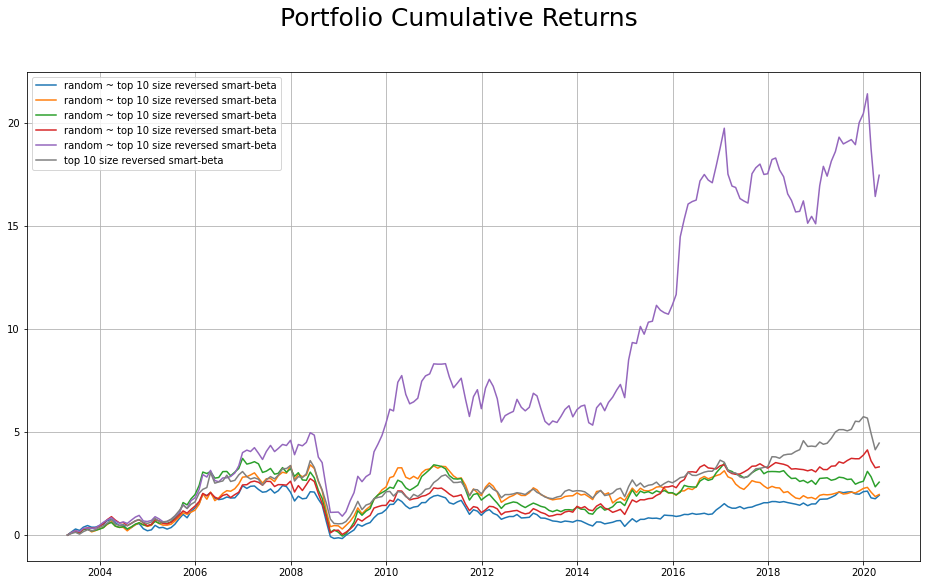

In [31]:
pqr.plot_cumulative_returns(*random_portfolios, benchmark=top_portfolio)